In [13]:
!pip install pyDOE

In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.8.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
from scipy.stats import norm
#getting collocation points
x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
y = np.linspace(-1, 1, 256)
t = np.linspace(0, 0.2, 1000)                     # 100 time points between 0 and 1 [100x1] 
usol=np.zeros((256,1000))
usol[:,0][:]=norm.pdf(x, 0, 0.5).T

#collocation points for every position and every time
X, Y, T = np.meshgrid(x, y ,t)


# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [3]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u = usol.flatten('F')[:,None] 

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [4]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:][:,None][:,:,0], X[0,:][:,None][:,:,0], T[0,:][:,None][:,:,0])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None][:,:,0], X[0,:][:,None][:,:,0], T[:,0][:,None][:,:,0])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None][:,:,0], X[0,:][:,None][:,:,0], T[:,0][:,None][:,:,0])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(3,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train 


# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [5]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
    
        cost=10 
        sigma2=0.25

        x_f = g[:,0:1]
        y_f = g[:,1:2]
        t_f = g[:,2:3]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(y_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], y_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            p_x = tape.gradient(z,x_f)
            p_y = tape.gradient(z,y_f)

        p_t = tape.gradient(z,t_f)    
        p_xx = tape.gradient(p_x, x_f)
        p_yy = tape.gradient(p_y, y_f)
        p_xy = tape.gradient(p_x, y_f)
        p_yx = tape.gradient(p_y, x_f)

        del tape

        p=self.evaluate(g)

        f = p_t - cost * p - cost * x_f * p_x - sigma2/2*p_xx + - sigma2/2*p_yy

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(loss_value, loss_u, loss_f, error_vec)

# *Solution Plot*

In [6]:
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(2, 3)
    gs0.update(top=1, bottom=0, left=0.1, right=2, wspace=0.3, hspace =0.4)
    ax = plt.subplot(gs0[0, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    #gs1 = gridspec.GridSpec(1, 3)
    #gs1.update(top=0.3, bottom=-0.1, left=0.1, right=2, wspace=0.5)

    ax = plt.subplot(gs0[1, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.s$', fontsize = 10)
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])

    ax = plt.subplot(gs0[1, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[500,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])
    ax.set_title('$t = 0.1s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs0[1, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[750,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])    
    ax.set_title('$t = 0.15s$', fontsize = 10)
    
    #plt.tight_layout()
    plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)   

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [ ]:
N_u = 10 #Total number of data points for 'u'
N_f = 100 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u, N_f)

layers = np.array([3,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,1000),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
#solutionplot(u_pred,X_u_train,u_train)

Metal device set to: Apple M1


In [ ]:
import pickle
filename = 'models/ornstein_uhlenbeck_lateral_ic.sav'
#pickle.dump(results, open(filename, 'wb')) #dump model



In [5]:
loaded_model = pickle.load(open(filename, 'rb')) #load model

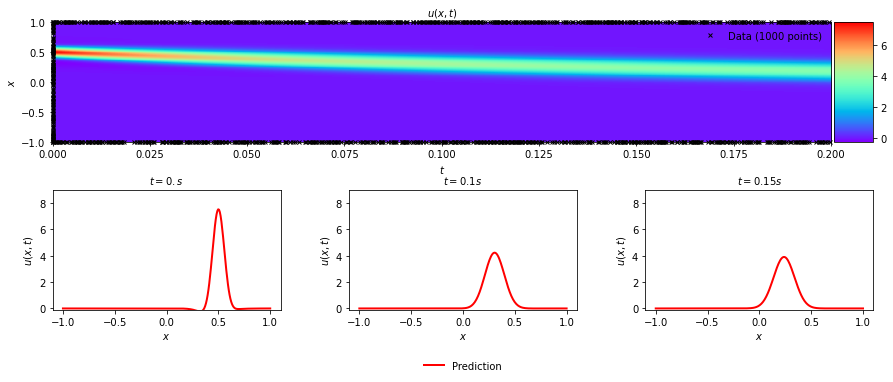

In [34]:
solutionplot(u_pred,X_u_train,u_train)

# Plot of collocation points

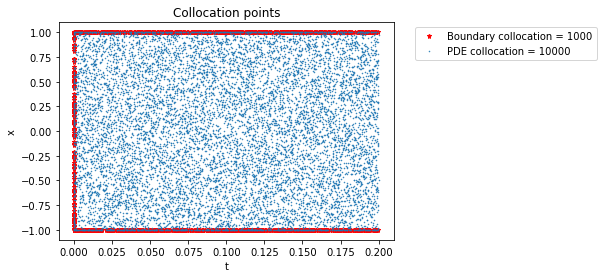

In [9]:
N_u = 1000 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

fig,ax = plt.subplots()

plt.plot(X_u_train[:,1], X_u_train[:,0], '*', color = 'red', markersize = 5, label = 'Boundary collocation = 1000')
plt.plot(X_f_train[:,1], X_f_train[:,0], 'o', markersize = 0.5, label = 'PDE collocation = 10000')

plt.xlabel('t')
plt.ylabel('x')
plt.title('Collocation points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig.savefig('collocation_points_Burgers.png', dpi = 500, bbox_inches='tight')

In [10]:
x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
t = np.linspace(0, 0.1, 1000)                     # 100 time points between 0 and 1 [100x1] 

X, T = np.meshgrid(x,t)
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_pred=PINN.evaluate(X_u_test)
u_pred = np.reshape(u_pred,(256,1000),order='F')  

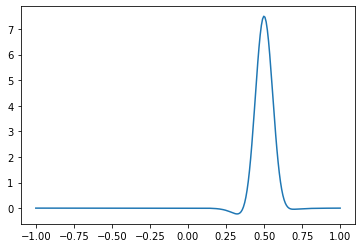

In [11]:
plt.plot(x, u_pred[:,1])

In [18]:
import ipywidgets

results = loaded_model

layers = np.array([3,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

u_pred = np.reshape(u_pred,(256,1000),order='F')  




def inter_pred(time):
    time = int(time * 10000)
    plt.plot(x, u_pred[:,time])
    plt.xlim(-1, 1)
    plt.ylim(0, 8)
    plt.grid()
        
        
ipywidgets.interact(inter_pred, time=(0, T.max() - T.max()/1000, T.max()/100))

interactive(children=(FloatSlider(value=0.098, description='time', max=0.1998, step=0.002), Output()), _dom_cl…

<function __main__.inter_pred(time)>